In [39]:
#–¥–æ–±–∞–≤–ª—è–µ–º –∏–º–ø–æ—Ä—Ç—ã
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.pipeline import make_pipeline
from tqdm.auto import tqdm
import warnings


In [40]:
#–ó–∞–≥—Ä—É–∂–∞–µ–º –¥–∞–Ω–Ω—ã–µ
df = pd.read_csv('cleaned_comments.csv', delimiter='\t', header=0)

#–£–¥–∞–ª—è–∫–º –∫–æ–ª–æ–Ω–∫–∏ Unnamed
df.drop(columns=[col for col in df.columns if col.startswith('Unnamed')], inplace=True)

#–°–æ–∑–¥–∞–Ω–∏–µ –Ω–æ–≤–æ–≥–æ —Å—Ç–æ–ª–±—Ü–∞ –¥–ª—è –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤
df['comment'] = ''

# –ü–µ—Ä–µ–±–æ—Ä –≤—Å–µ—Ö —Å—Ç—Ä–æ–∫ –¥–ª—è –ø–µ—Ä–µ–º–µ—â–µ–Ω–∏—è –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–µ–≤
for idx, row in df.iterrows():
    #–ü–æ–∏—Å–∫ –ø–µ—Ä–≤–æ–≥–æ –Ω–µ–ø—É—Å—Ç–æ–≥–æ —Å—Ç—Ä–æ–∫–æ–≤–æ–≥–æ –∑–Ω–∞—á–µ–Ω–∏—è –≤ —Å—Ç—Ä–æ–∫–µ
    comment = next((v for v in row if isinstance(v, str) and v.strip()), '')
    
    #–ó–∞–ø–∏—Å—å –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏—è –≤ –Ω–æ–≤—ã–π —Å—Ç–æ–ª–±–µ—Ü
    df.at[idx, 'comment'] = comment
    
    #–û–±–Ω—É–ª–µ–Ω–∏–µ –∏—Å—Ö–æ–¥–Ω—ã—Ö —Å—Ç–æ–ª–±—Ü–æ–≤ –∏ —É—Å—Ç–∞–Ω–æ–≤–∫–∞ —Ñ–ª–∞–≥–æ–≤
    for col in df.columns[:-1]:  #–í—Å–µ —Å—Ç–æ–ª–±—Ü—ã –∫—Ä–æ–º–µ –Ω–æ–≤–æ–≥–æ 'comment'
        df.at[idx, col] = 1 if str(row[col]).strip() == comment.strip() else 0

#–°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞
df.to_csv('processed_comments.csv', index=False)

‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï
‚îÇ –û–±–Ω–∞—Ä—É–∂–µ–Ω–Ω—ã–µ —Å—Ç–æ–ª–±—Ü—ã –≤ —Ñ–∞–π–ª–µ:  ‚îÇ
‚ïò‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïõ
['–í–æ–ø—Ä–æ—Å —Ä–µ—à–µ–Ω', '–í–æ–ø—Ä–æ—Å –Ω–µ —Ä–µ—à–µ–Ω ', '–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è –∑–∞—è–≤–∫–∏', '–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ —Ä–∞–±–æ—Ç—ã —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–æ–≤', '–ù—Ä–∞–≤–∏—Ç—Å—è —Å–∫–æ—Ä–æ—Å—Ç—å –æ—Ç—Ä–∞–±–æ—Ç–∫–∏ –∑–∞—è–≤–æ–∫', '–ü–æ–Ω—Ä–∞–≤–∏–ª–æ—Å—å –≤—ã–ø–æ–ª–Ω–µ–Ω–∏–µ –∑–∞—è–≤–∫–∏', 'comment'] 



–ü—Ä–æ–≥—Ä–µ—Å—Å –æ–±—Ä–∞–±–æ—Ç–∫–∏:   0%|          | 0/1735 [00:00<?, ?it/s]

–ü—Ä–æ–≥—Ä–µ—Å—Å –æ–±—Ä–∞–±–æ—Ç–∫–∏:   0%|          | 0/1735 [00:00<?, ?it/s]

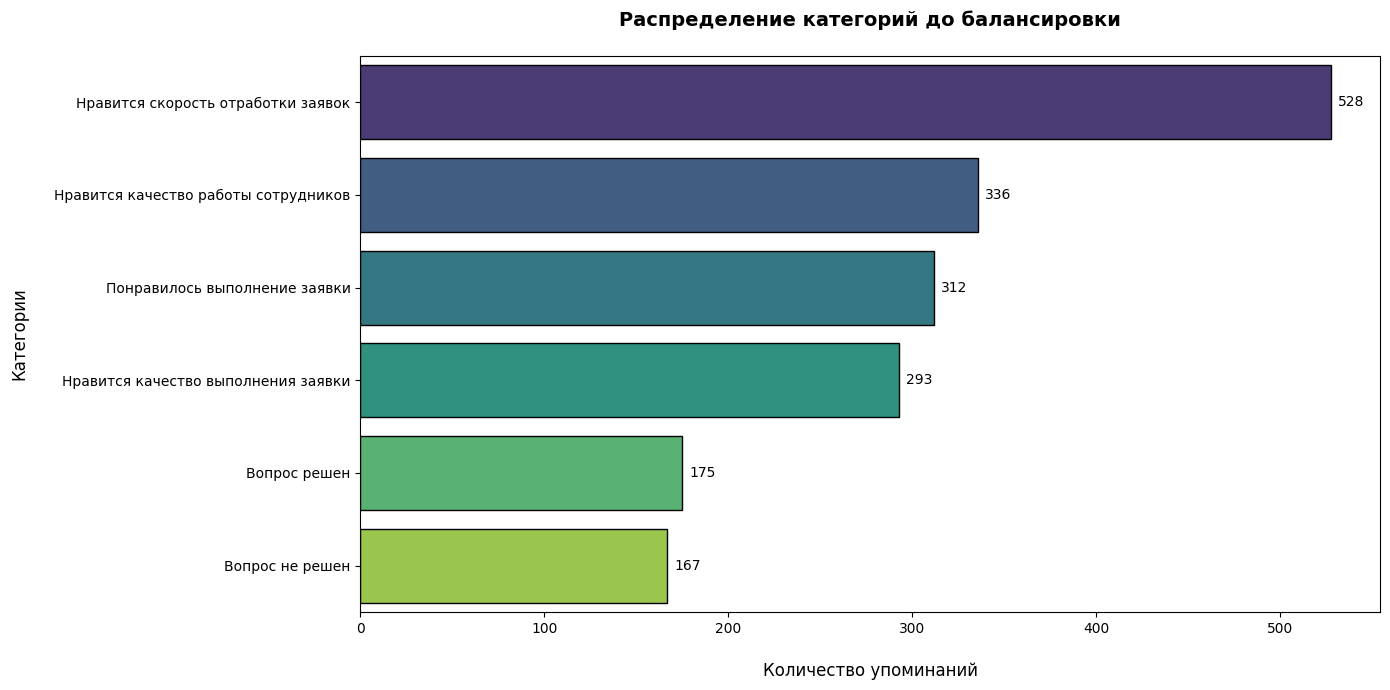

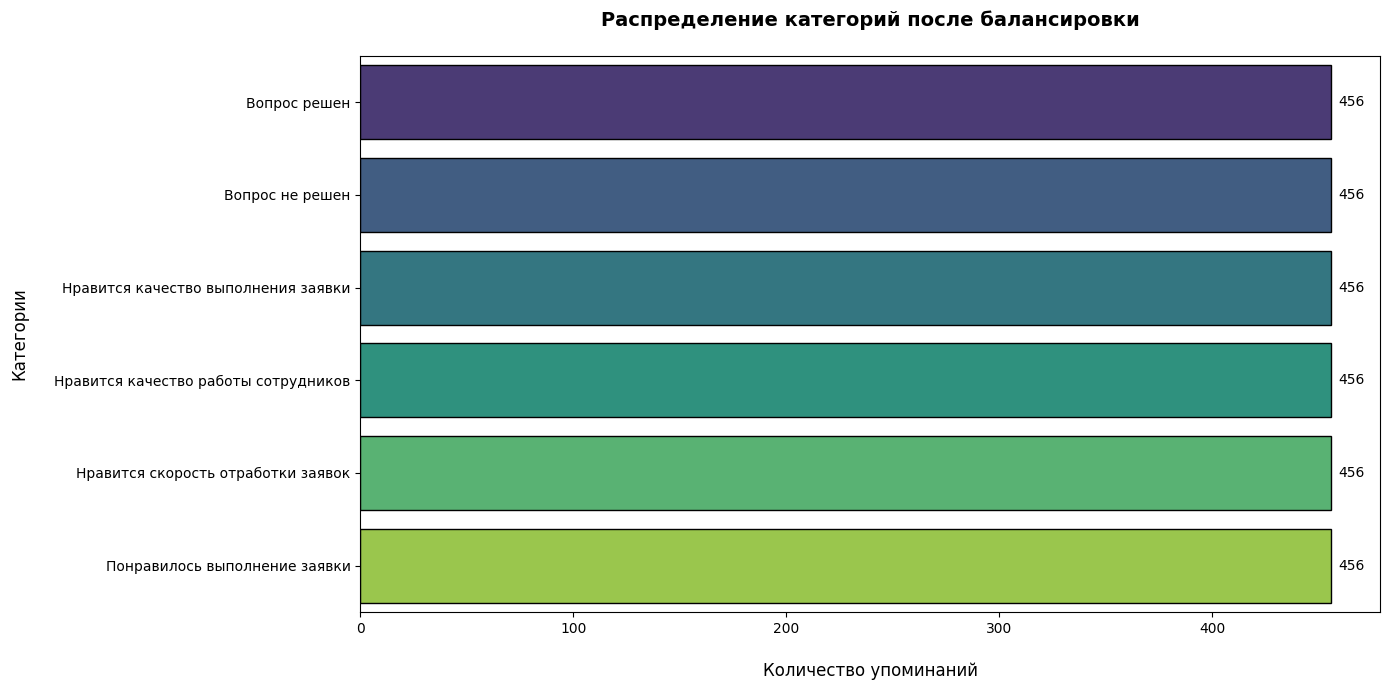

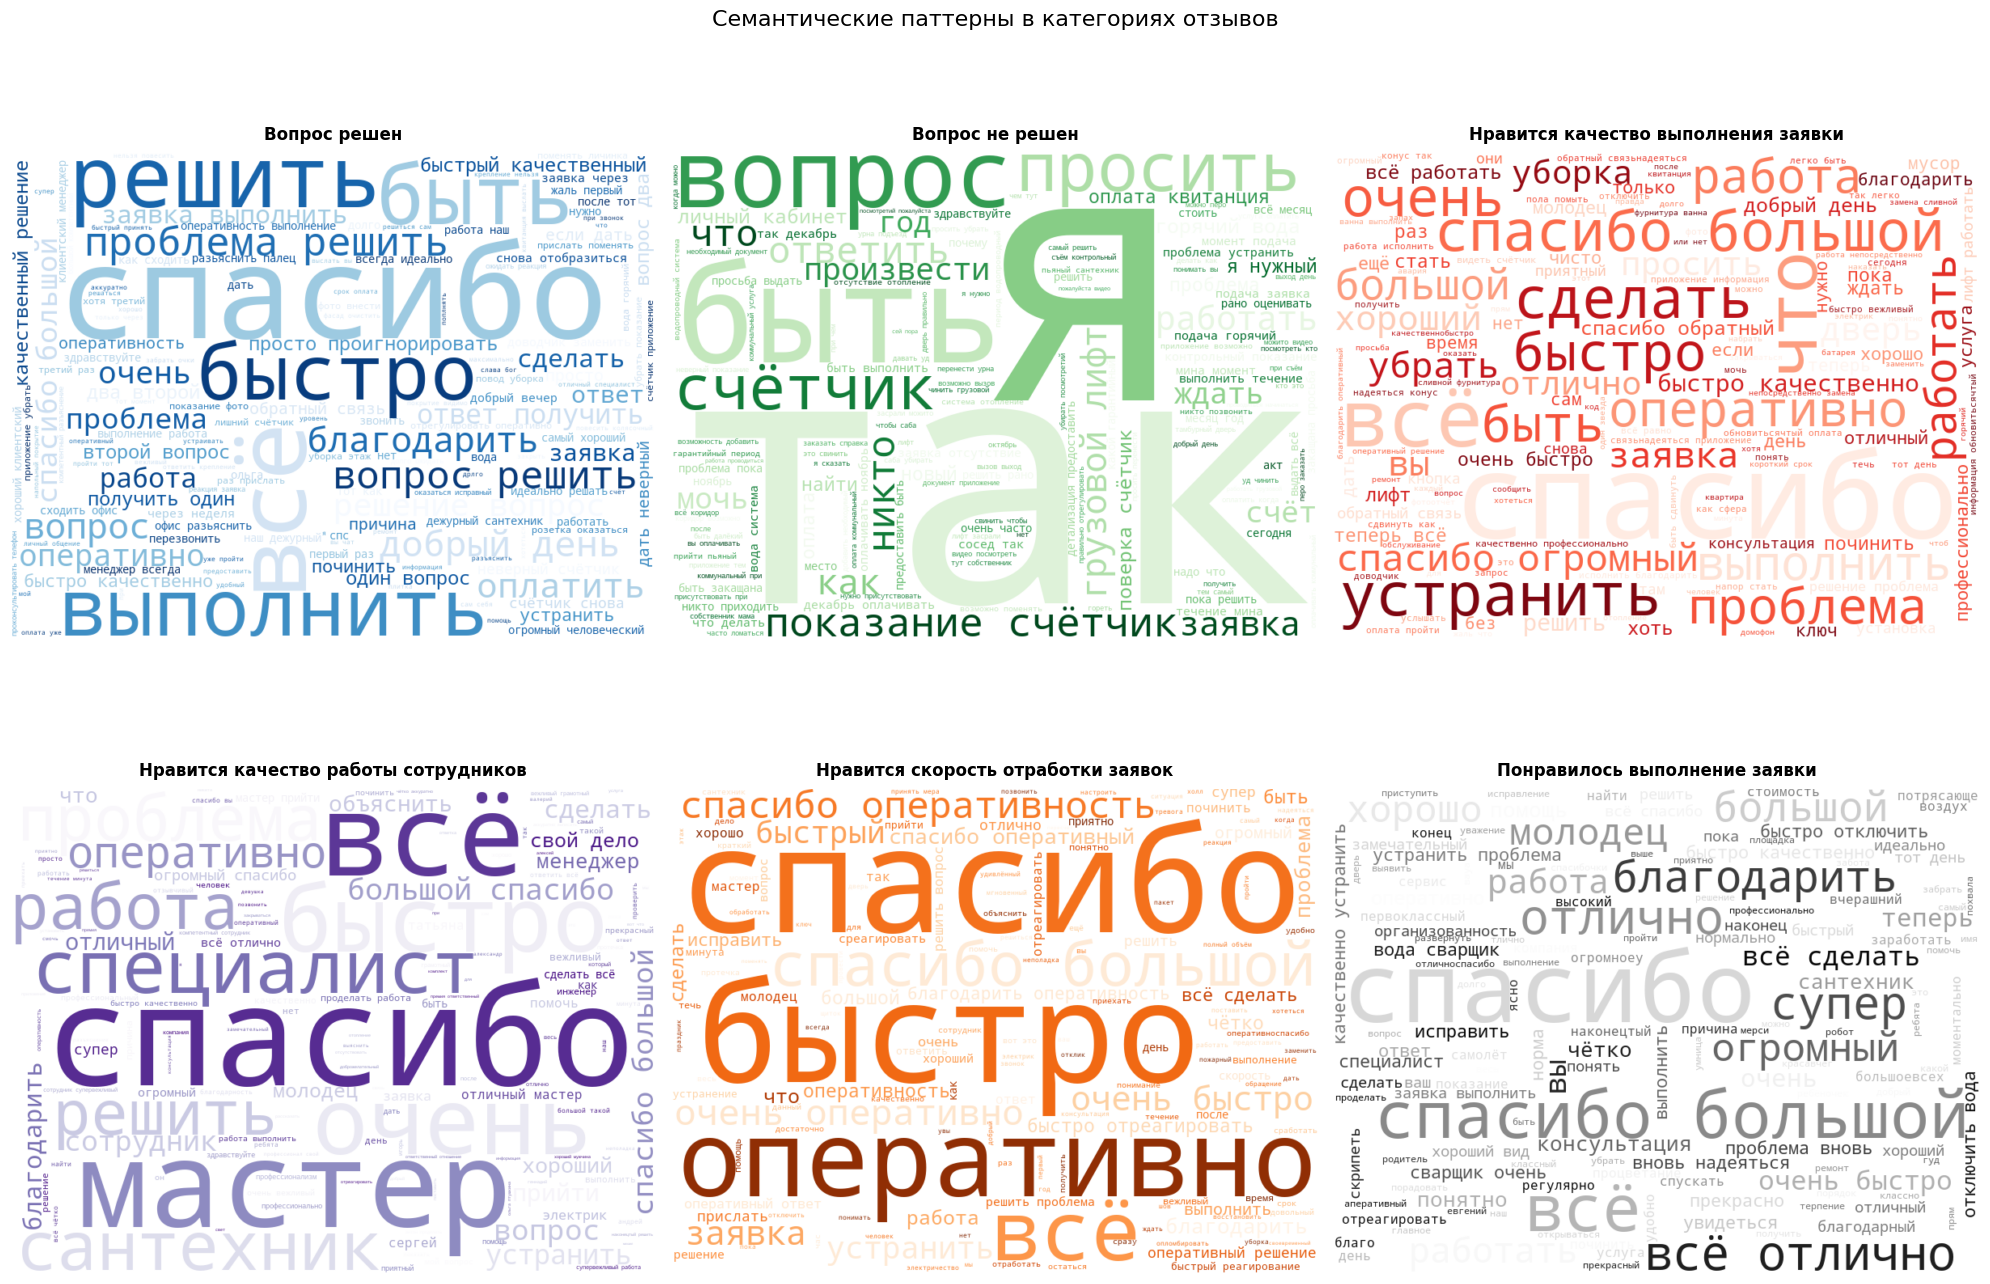


‚úÖ –î–∞–Ω–Ω—ã–µ —É—Å–ø–µ—à–Ω–æ —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã


In [41]:
#–ê–Ω–∞–ª–∏–∑ –¥–∞–Ω–Ω—ã—Ö, –±–∞–ª–∞–Ω—Å –∫–ª–∞—Å—Å–æ–≤, –ø–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö –∫ —Ä–∞–±–æ—Ç–µ.
#–ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –∏–Ω—Å—Ç—Ä—É–º–µ–Ω—Ç–æ–≤
morph = MorphAnalyzer()
tqdm.pandas(desc="–ü—Ä–æ–≥—Ä–µ—Å—Å –æ–±—Ä–∞–±–æ—Ç–∫–∏")

#–ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è –æ–±—Ä–∞–±–æ—Ç–∫–∏
CONFIG = {
    "random_state": 42,
    "max_features": 500,
    "ngram_range": (1, 2),
    "min_samples": 10,
    "text_columns": {
        '–í–æ–ø—Ä–æ—Å —Ä–µ—à–µ–Ω': ['–≤–æ–ø—Ä–æ—Å —Ä–µ—à–µ–Ω', '—Ä–µ—à–µ–Ω', '—Ä–µ—à–µ–Ω–æ', '—Å—Ç–∞—Ç—É—Å —Ä–µ—à–µ–Ω'],
        '–í–æ–ø—Ä–æ—Å –Ω–µ —Ä–µ—à–µ–Ω': ['–≤–æ–ø—Ä–æ—Å –Ω–µ —Ä–µ—à–µ–Ω', '–≤–æ–ø—Ä–æ—Å –Ω–µ —Ä–µ—à–µ–Ω ', '–Ω–µ —Ä–µ—à–µ–Ω', '–Ω–µ —Ä–µ—à–µ–Ω–æ'],
        '–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è –∑–∞—è–≤–∫–∏': ['–Ω—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è –∑–∞—è–≤–∫–∏', '–∫–∞—á–µ—Å—Ç–≤–æ –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è'],
        '–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ —Ä–∞–±–æ—Ç—ã —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–æ–≤': ['–Ω—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ —Ä–∞–±–æ—Ç—ã —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–æ–≤', '–∫–∞—á–µ—Å—Ç–≤–æ —Ä–∞–±–æ—Ç—ã'],
        '–ù—Ä–∞–≤–∏—Ç—Å—è —Å–∫–æ—Ä–æ—Å—Ç—å –æ—Ç—Ä–∞–±–æ—Ç–∫–∏ –∑–∞—è–≤–æ–∫': ['–Ω—Ä–∞–≤–∏—Ç—Å—è —Å–∫–æ—Ä–æ—Å—Ç—å –æ—Ç—Ä–∞–±–æ—Ç–∫–∏ –∑–∞—è–≤–æ–∫', '—Å–∫–æ—Ä–æ—Å—Ç—å –æ–±—Ä–∞–±–æ—Ç–∫–∏'],
        '–ü–æ–Ω—Ä–∞–≤–∏–ª–æ—Å—å –≤—ã–ø–æ–ª–Ω–µ–Ω–∏–µ –∑–∞—è–≤–∫–∏': ['–ø–æ–Ω—Ä–∞–≤–∏–ª–æ—Å—å –≤—ã–ø–æ–ª–Ω–µ–Ω–∏–µ –∑–∞—è–≤–∫–∏', '–æ–±—â–∞—è –æ—Ü–µ–Ω–∫–∞'],
        'comment': ['comment', '—Ç–µ–∫—Å—Ç –æ—Ç–∑—ã–≤–∞', '–æ—Ç–∑—ã–≤', '—Ç–µ–∫—Å—Ç']
    }
}

#–∑–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö, –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –Ω–∞–∑–≤–∞–Ω–∏–π –∫–æ–ª–æ–Ω–æ–∫ –∫ –µ–¥–∏–Ω–æ–º—É –≤–∏–¥—É
def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path, sep=',', encoding='utf-8')
    print("‚ïí‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïï")
    print("‚îÇ –û–±–Ω–∞—Ä—É–∂–µ–Ω–Ω—ã–µ —Å—Ç–æ–ª–±—Ü—ã –≤ —Ñ–∞–π–ª–µ:  ‚îÇ")
    print("‚ïò‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïõ")
    print(df.columns.tolist(), '\n')
    
    column_mapping = {}
    for target, variants in CONFIG['text_columns'].items():
        for col in df.columns:
            norm_col = re.sub(r'\s+', ' ', col).strip().lower()
            norm_variants = [re.sub(r'\s+', ' ', v).strip().lower() for v in variants]
            if norm_col in norm_variants:
                column_mapping[col] = target
                break
                
    return df.rename(columns=column_mapping)

#–ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞ —Ç–µ–∫—Å—Ç–∞
class TextPreprocessor:
    def __init__(self, morph):
        self.morph = morph
        self.regex = {
            'clean': re.compile(r'[^–∞-—è—ë\s]'),
            'spaces': re.compile(r'\s+')
        }
    
    def preprocess(self, text):
        text = str(text).lower()
        text = self.regex['clean'].sub('', text)
        text = self.regex['spaces'].sub(' ', text).strip()
        return text
    
    def lemmatize(self, text):
        words = text.split()
        return ' '.join([
            self.morph.parse(word)[0].normal_form 
            for word in words 
            if len(word) > 2
        ])

#–ë–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö
def balance_dataset(df, categories):
    df = df.copy()
    df['multi_label'] = df[categories].sum(axis=1)
    df = df[df['multi_label'] <= 1]
    
    labeled = df[df['multi_label'] == 1].copy()
    unlabeled = df[df['multi_label'] == 0].copy()
    
    labeled['label'] = labeled[categories].idxmax(axis=1)
    ros = RandomOverSampler(random_state=CONFIG['random_state'])
    X_res, y_res = ros.fit_resample(labeled[['lemmatized', 'text_length']], labeled['label'])
    
    df_resampled = pd.DataFrame(X_res, columns=['lemmatized', 'text_length'])
    df_resampled['label'] = y_res
    
    for cat in categories:
        df_resampled[cat] = (df_resampled['label'] == cat).astype(int)
    
    return pd.concat([df_resampled.drop('label', axis=1), unlabeled], axis=0)

#–§—É–Ω–∫—Ü–∏–∏ –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏
def plot_distribution(df, categories, title):
    plt.figure(figsize=(14, 7))
    distribution = df[categories].sum().sort_values(ascending=False)
    
    ax = sns.barplot(
        x=distribution.values,
        y=distribution.index,
        palette="viridis",
        edgecolor='black'
    )
    
    plt.title(f'{title}\n', fontsize=14, fontweight='bold')
    plt.xlabel('\n–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–ø–æ–º–∏–Ω–∞–Ω–∏–π', fontsize=12)
    plt.ylabel('–ö–∞—Ç–µ–≥–æ—Ä–∏–∏\n', fontsize=12)
    
    for p in ax.patches:
        ax.annotate(
            f"{int(p.get_width()):,}", 
            (p.get_width(), p.get_y() + p.get_height()/2),
            ha='left', va='center',
            fontsize=10,
            color='black',
            xytext=(5, 0),
            textcoords='offset points'
        )
    
    plt.tight_layout()
    plt.show()

def generate_wordclouds(df, categories):
    plt.figure(figsize=(20, 15))
    colors = ['Blues', 'Greens', 'Reds', 'Purples', 'Oranges', 'Greys']
    
    for i, (col, color) in enumerate(zip(categories, colors), 1):
        text = ' '.join(df[df[col] == 1]['lemmatized'])
        wordcloud = WordCloud(
            width=800,
            height=600,
            background_color='white',
            colormap=color,
            max_words=150,
            contour_width=1,
            contour_color='steelblue'
        ).generate(text)
        
        plt.subplot(2, 3, i)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(col, fontsize=12, pad=10, fontweight='bold')
        plt.axis('off')
    
    plt.suptitle('–°–µ–º–∞–Ω—Ç–∏—á–µ—Å–∫–∏–µ –ø–∞—Ç—Ç–µ—Ä–Ω—ã –≤ –∫–∞—Ç–µ–≥–æ—Ä–∏—è—Ö –æ—Ç–∑—ã–≤–æ–≤\n', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

#–ì–ª–∞–≤–Ω—ã–π –ø—Ä–æ—Ü–µ—Å—Å –æ–±—Ä–∞–±–æ—Ç–∫–∏
def main():
    df = load_and_prepare_data('processed_comments.csv')
    
    preprocessor = TextPreprocessor(morph)
    df['cleaned'] = df['comment'].progress_apply(preprocessor.preprocess)
    df['lemmatized'] = df['cleaned'].progress_apply(preprocessor.lemmatize)
    df['text_length'] = df['lemmatized'].apply(lambda x: len(x.split()))
    
    categories = list(CONFIG['text_columns'].keys())[:-1]
    plot_distribution(df, categories, '–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–π –¥–æ –±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∫–∏')
    
    df_balanced = balance_dataset(df, categories)
    plot_distribution(df_balanced, categories, '–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–π –ø–æ—Å–ª–µ –±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∫–∏')
    
    tfidf = TfidfVectorizer(
        ngram_range=CONFIG['ngram_range'],
        max_features=CONFIG['max_features'],
        token_pattern=r'(?u)\b[–∞-—è—ë]{3,}\b'
    )
    
    tfidf_matrix = tfidf.fit_transform(df_balanced['lemmatized'])
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=[f"tfidf_{re.sub(r'[^a-z0-9]', '_', col)}" for col in tfidf.get_feature_names_out()]
    )
    
    final_df = pd.concat([df_balanced.reset_index(drop=True), tfidf_df], axis=1)
    generate_wordclouds(final_df, categories)
    
    output_columns = categories + ['lemmatized', 'text_length'] + list(tfidf_df.columns)
    final_df[output_columns].to_csv('processed_data_final1.csv', index=False)
    print("\n‚úÖ –î–∞–Ω–Ω—ã–µ —É—Å–ø–µ—à–Ω–æ —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã")

if __name__ == "__main__":
    main()


üîç –ê–Ω–∞–ª–∏–∑ —Ç–æ–ø-20 –∑–Ω–∞—á–∏–º—ã—Ö —Å–ª–æ–≤ –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º...


–û–±—Ä–∞–±–æ—Ç–∫–∞ –∫–∞—Ç–µ–≥–æ—Ä–∏–π:   0%|          | 0/6 [00:00<?, ?it/s]

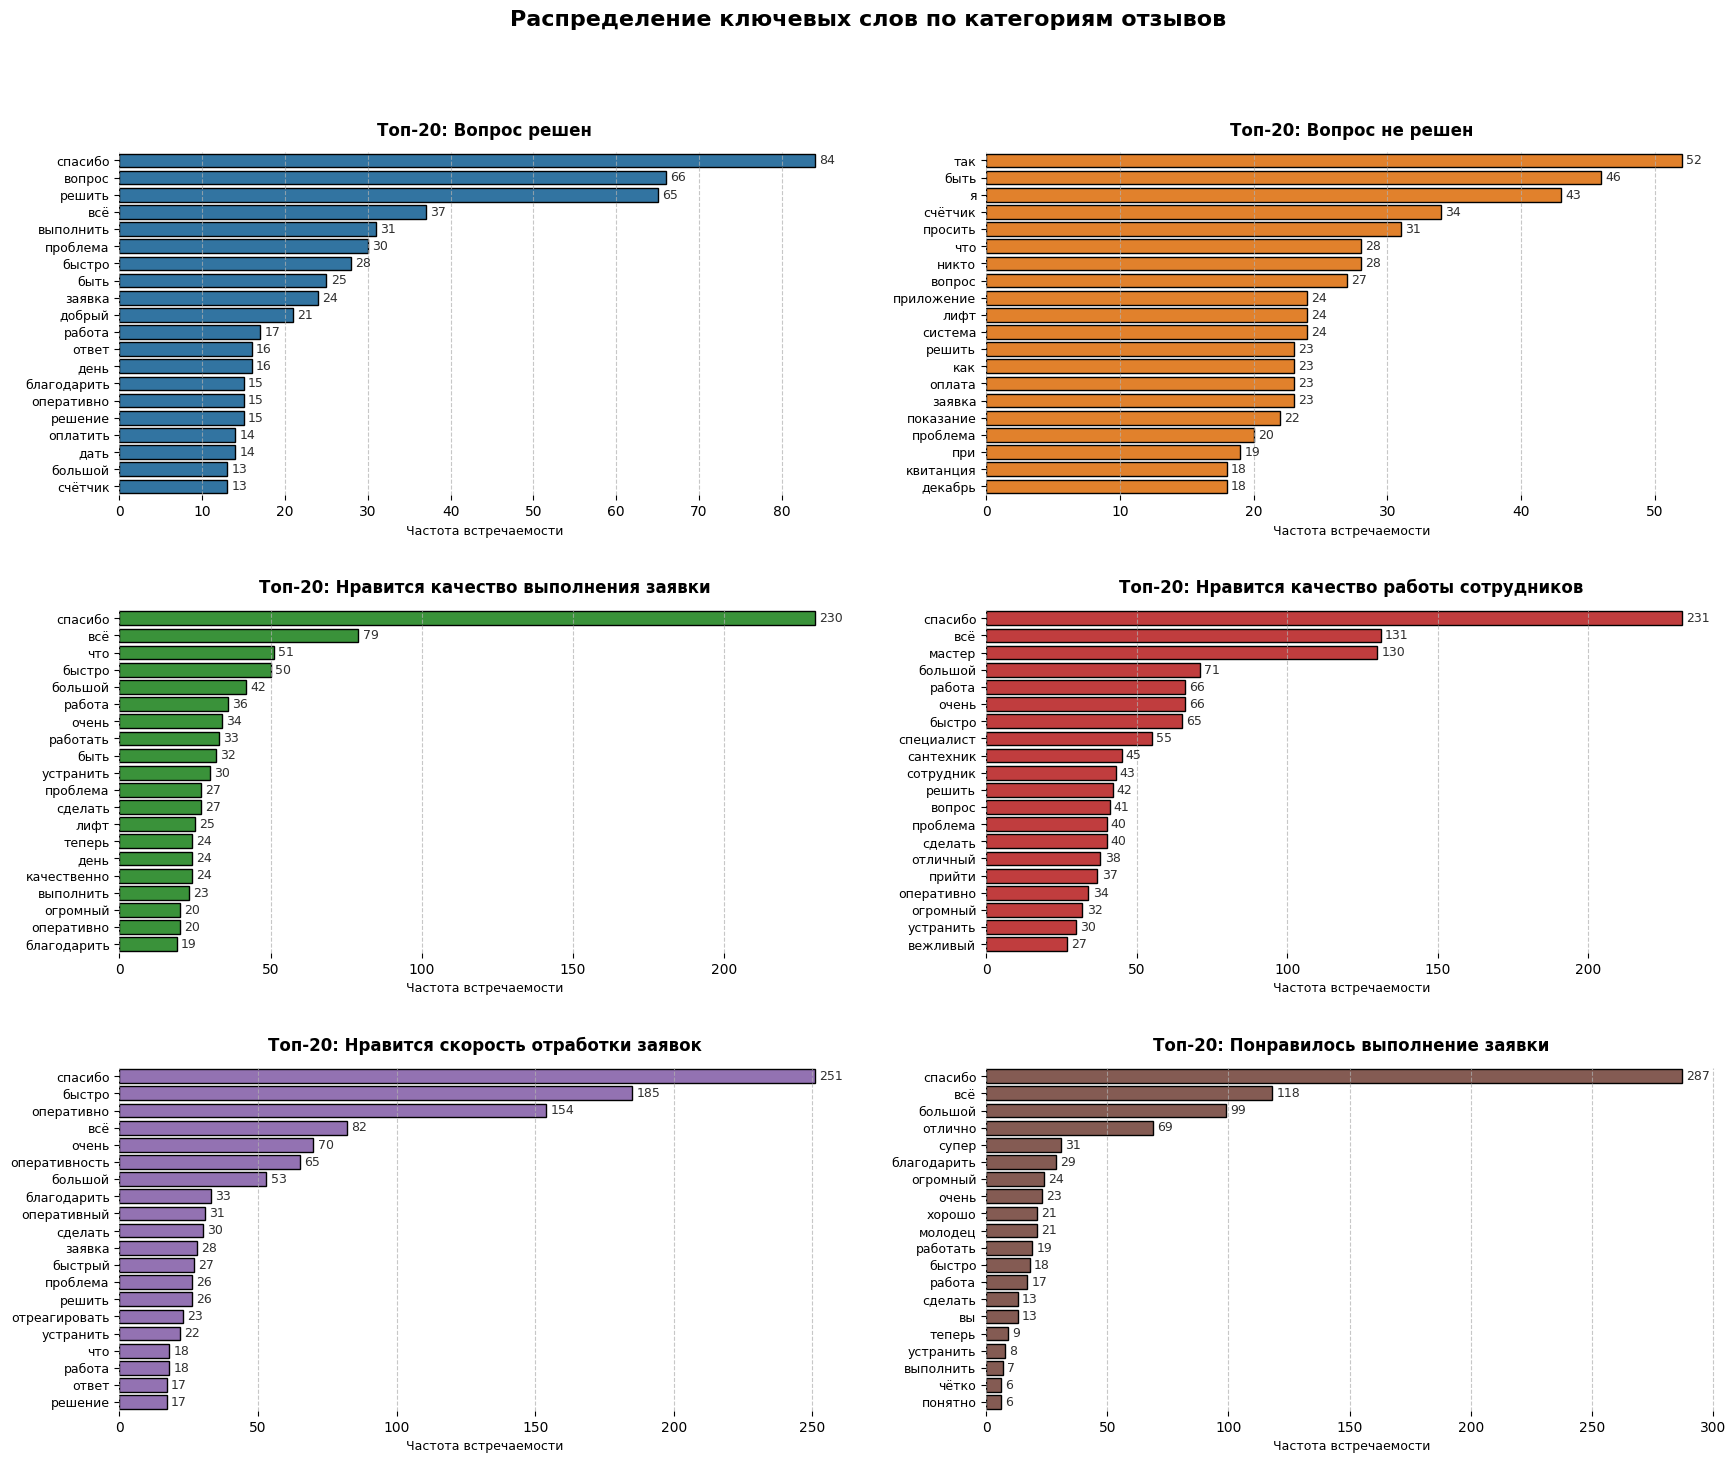

In [42]:
#–í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Å–ª–æ–≤ –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º
def load_processed_data(file_path='processed_data_final1.csv'):
    """–ó–∞–≥—Ä—É–∑–∫–∞ –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö"""
    df = pd.read_csv(file_path)
    return df

def analyze_top_words(df):
    """–ê–Ω–∞–ª–∏–∑ –∏ –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ç–æ–ø-20 —Å–ª–æ–≤ –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º"""
    print("\nüîç –ê–Ω–∞–ª–∏–∑ —Ç–æ–ø-20 –∑–Ω–∞—á–∏–º—ã—Ö —Å–ª–æ–≤ –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º...")
    
    categories = [
        '–í–æ–ø—Ä–æ—Å —Ä–µ—à–µ–Ω',
        '–í–æ–ø—Ä–æ—Å –Ω–µ —Ä–µ—à–µ–Ω',
        '–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è –∑–∞—è–≤–∫–∏',
        '–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ —Ä–∞–±–æ—Ç—ã —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–æ–≤',
        '–ù—Ä–∞–≤–∏—Ç—Å—è —Å–∫–æ—Ä–æ—Å—Ç—å –æ—Ç—Ä–∞–±–æ—Ç–∫–∏ –∑–∞—è–≤–æ–∫',
        '–ü–æ–Ω—Ä–∞–≤–∏–ª–æ—Å—å –≤—ã–ø–æ–ª–Ω–µ–Ω–∏–µ –∑–∞—è–≤–∫–∏'
    ]
    
    #–ù–∞—Å—Ç—Ä–æ–π–∫–∞ –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏
    plt.figure(figsize=(18, 15))
    palettes = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    #–ü—Ä–æ–≥—Ä–µ—Å—Å-–±–∞—Ä
    pbar = tqdm(zip(categories, palettes), total=len(categories), desc="–û–±—Ä–∞–±–æ—Ç–∫–∞ –∫–∞—Ç–µ–≥–æ—Ä–∏–π")
    
    for i, (category, color) in enumerate(pbar, 1):
        ax = plt.subplot(3, 2, i)
        
        #–§–∏–ª—å—Ç—Ä–∞—Ü–∏—è –∏ –ø–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö
        category_data = df[df[category] == 1]
        texts = category_data['lemmatized'].fillna('').astype(str)
        
        #–ü–æ–¥—Å—á–µ—Ç —Å–ª–æ–≤
        word_counts = Counter(" ".join(texts).split())
        top_words = word_counts.most_common(20)
        
        #–°–æ–∑–¥–∞–Ω–∏–µ DataFrame –¥–ª—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏
        words_df = pd.DataFrame(top_words, columns=['word', 'count'])
        
        #–ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–∞
        sns.barplot(x='count', y='word', data=words_df, 
                    ax=ax, color=color, edgecolor='black')
        
        #–ê–Ω–Ω–æ—Ç–∞—Ü–∏–∏
        ax.bar_label(ax.containers[0], fmt='%d', 
                    padding=3, fontsize=9, color='#2f2f2f')
        
        #–û—Ñ–æ—Ä–º–ª–µ–Ω–∏–µ
        ax.set_title(f'–¢–æ–ø-20: {category}', fontsize=12, pad=12, fontweight='bold')
        ax.set_xlabel('–ß–∞—Å—Ç–æ—Ç–∞ –≤—Å—Ç—Ä–µ—á–∞–µ–º–æ—Å—Ç–∏', fontsize=9)
        ax.set_ylabel('')
        ax.tick_params(axis='y', labelsize=9)
        ax.grid(axis='x', linestyle='--', alpha=0.7)
        
        #–£–¥–∞–ª–µ–Ω–∏–µ —Ä–∞–º–æ–∫
        for spine in ax.spines.values():
            spine.set_visible(False)

    plt.suptitle('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–ª—é—á–µ–≤—ã—Ö —Å–ª–æ–≤ –ø–æ –∫–∞—Ç–µ–≥–æ—Ä–∏—è–º –æ—Ç–∑—ã–≤–æ–≤\n', 
                fontsize=16, y=0.99, fontweight='bold')
    plt.tight_layout(pad=3.0)
    plt.show()

if __name__ == "__main__":
    data = load_processed_data()
    analyze_top_words(data)

–û–±—Ä–∞–±–æ—Ç–∫–∞ —Ç–µ–∫—Å—Ç–∞:   0%|          | 0/2737 [00:00<?, ?it/s]


–†–µ–∑—É–ª—å—Ç–∞—Ç—ã –≤–∞–ª–∏–¥–∞—Ü–∏–∏:


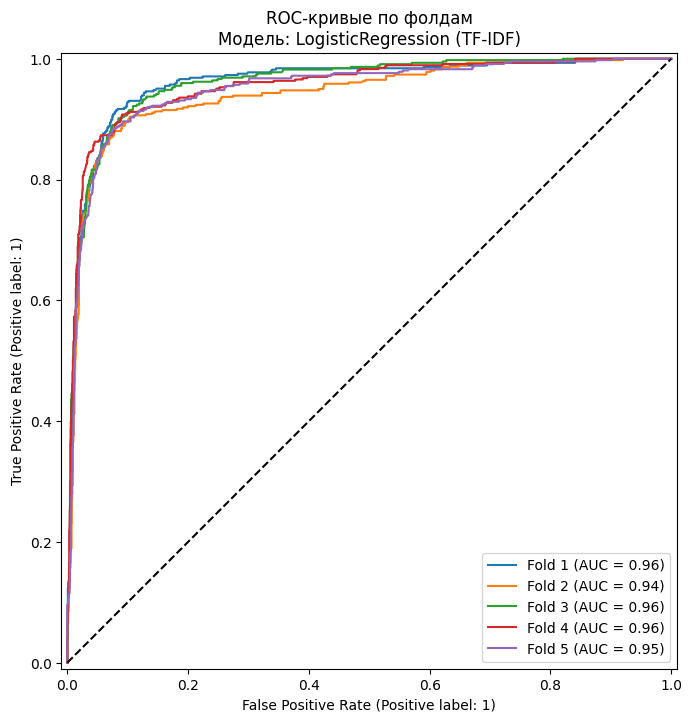

–°—Ä–µ–¥–Ω–∏–π AUC: 0.952
–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è –∑–∞—è–≤–∫–∏: 0.919 ¬± 0.021
–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ —Ä–∞–±–æ—Ç—ã —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–æ–≤: 0.961 ¬± 0.010
–ù—Ä–∞–≤–∏—Ç—Å—è —Å–∫–æ—Ä–æ—Å—Ç—å –æ—Ç—Ä–∞–±–æ—Ç–∫–∏ –∑–∞—è–≤–æ–∫: 0.969 ¬± 0.010
–í–æ–ø—Ä–æ—Å —Ä–µ—à–µ–Ω: 0.921 ¬± 0.017
–í–æ–ø—Ä–æ—Å –Ω–µ —Ä–µ—à–µ–Ω: 0.990 ¬± 0.002

–¢–µ—Å—Ç–æ–≤—ã–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è:

–û—Ç–∑—ã–≤ 1:
–¢–µ–∫—Å—Ç: –ë—ã—Å—Ç—Ä–æ –∏ –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω–æ –≤—ã–ø–æ–ª–Ω–∏–ª–∏ —Ä–∞–±–æ—Ç—É
–ö–∞—Ç–µ–≥–æ—Ä–∏–∏: ['–í–æ–ø—Ä–æ—Å —Ä–µ—à–µ–Ω']

–û—Ç–∑—ã–≤ 2:
–¢–µ–∫—Å—Ç: –ü—Ä–∏—à–ª–æ—Å—å –∂–¥–∞—Ç—å —Ç—Ä–∏ –¥–Ω—è, —Ä–µ–∑—É–ª—å—Ç–∞—Ç –ø–ª–æ—Ö–æ–π
–ö–∞—Ç–µ–≥–æ—Ä–∏–∏: ['–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è –∑–∞—è–≤–∫–∏']

–û—Ç–∑—ã–≤ 3:
–¢–µ–∫—Å—Ç: 
–ö–∞—Ç–µ–≥–æ—Ä–∏–∏: ['–í–æ–ø—Ä–æ—Å –Ω–µ —Ä–µ—à–µ–Ω']

–û—Ç–∑—ã–≤ 4:
–¢–µ–∫—Å—Ç: –°–æ—Ç—Ä—É–¥–Ω–∏–∫ –æ–ø–æ–∑–¥–∞–ª, –Ω–æ –ø—Ä–æ–±–ª–µ–º—É —Ä–µ—à–∏–ª
–ö–∞—Ç–µ–≥–æ—Ä–∏–∏: ['–í–æ–ø—Ä–æ—Å —Ä–µ—à–µ–Ω']

–û—Ç–∑—ã–≤ 5:
–¢–µ–∫—Å—Ç: –ù

In [ ]:
#–ù–∞–∏–ª—É—á—à–∞—è –º–æ–¥–µ–ª—å
morph = MorphAnalyzer()

#–§—É–Ω–∫—Ü–∏–∏ –ø—Ä–µ–ø—Ä–æ—Ü–µ—Å—Å–∏–Ω–≥–∞ —Ç–µ–∫—Å—Ç–∞
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'\b–Ω–µ\s+(\w+)', r'–Ω–µ_\1', text)
    words = []
    for word in re.findall(r'\b[\w-]+\b', text):
        p = morph.parse(word)[0]
        words.append(p.normal_form)
    return ' '.join(words)

#–ó–∞–≥—Ä—É–∑–∫–∞ –∏ –ø–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö
def load_and_prepare_data(file_path='processed_data_final1.csv'):
    df = pd.read_csv(file_path, encoding='utf-8')
    text_column = [col for col in df.columns if df[col].dtype == 'object' and df[col].str.len().mean() > 20][0]
    
    tqdm.pandas(desc="–û–±—Ä–∞–±–æ—Ç–∫–∞ —Ç–µ–∫—Å—Ç–∞")
    df['processed_text'] = df[text_column].progress_apply(preprocess_text)
    
    categories = [
        '–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è –∑–∞—è–≤–∫–∏',
        '–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ —Ä–∞–±–æ—Ç—ã —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–æ–≤',
        '–ù—Ä–∞–≤–∏—Ç—Å—è —Å–∫–æ—Ä–æ—Å—Ç—å –æ—Ç—Ä–∞–±–æ—Ç–∫–∏ –∑–∞—è–≤–æ–∫',
        '–í–æ–ø—Ä–æ—Å —Ä–µ—à–µ–Ω',
        '–í–æ–ø—Ä–æ—Å –Ω–µ —Ä–µ—à–µ–Ω'
    ]
    df = df.dropna(subset=categories)
    return df['processed_text'].values, df[categories].values, categories

#–ü–∞–π–ø–ª–∞–π–Ω –º–æ–¥–µ–ª–∏
def build_model():
    return make_pipeline(
        TfidfVectorizer(max_features=10000, ngram_range=(1,2)), 
        OneVsRestClassifier(LogisticRegression(C=0.9, solver='saga', max_iter=1000, class_weight='balanced', random_state=42))
    )
    
#–ö—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏—è
def cross_validate(X, y, categories, n_splits=5, model_name="Logistic Regression"):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {'auc_scores': [], 'category_auc': {c: [] for c in categories}}
    
    plt.figure(figsize=(10,8))
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y.argmax(1))):
        model = build_model().fit(X[train_idx], y[train_idx])
        y_proba = model.predict_proba(X[test_idx])
        
        results['auc_scores'].append(roc_auc_score(y[test_idx], y_proba, average='macro'))
        for i, cat in enumerate(categories):
            results['category_auc'][cat].append(roc_auc_score(y[test_idx][:,i], y_proba[:,i]))
        
        RocCurveDisplay.from_predictions(
            LabelBinarizer().fit_transform(y[test_idx]).ravel(),
            y_proba.ravel(),
            name=f"Fold {fold+1}",
            ax=plt.gca()
        )
    
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f'ROC-–∫—Ä–∏–≤—ã–µ –ø–æ —Ñ–æ–ª–¥–∞–º\n–ú–æ–¥–µ–ª—å: {model_name}')
    plt.legend()
    plt.show()
    return results

#–ì–µ–Ω–µ—Ä–∞—Ü–∏—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π
def predict_with_threshold(model, texts, categories, threshold=0.25):
    processed = [preprocess_text(t) for t in texts]
    probas = model.predict_proba(processed)
    predictions = []
    for text, proba in zip(texts, probas):
        max_score = np.max(proba)
        selected = [(cat, score) for cat, score in zip(categories, proba) if score >= max(threshold, max_score)]
        predictions.append({
            'text': text,
            'categories': [cat for cat, _ in selected],
            'probabilities': dict(zip(categories, proba)),
            'max_score': float(max_score)
        })
    return predictions

#–ì–ª–∞–≤–Ω–∞—è —Ñ—É–Ω–∫—Ü–∏—è
def main():
    X, y, cats = load_and_prepare_data()
    model = build_model().fit(X, y)
    
    print("\n–†–µ–∑—É–ª—å—Ç–∞—Ç—ã –≤–∞–ª–∏–¥–∞—Ü–∏–∏:")
    cv_results = cross_validate(X, y, cats, model_name="LogisticRegression (TF-IDF)")
    print(f"–°—Ä–µ–¥–Ω–∏–π AUC: {np.mean(cv_results['auc_scores']):.3f}")
    for cat in cats:
        print(f"{cat}: {np.mean(cv_results['category_auc'][cat]):.3f} ¬± {np.std(cv_results['category_auc'][cat]):.3f}")

    test_texts = [
        "–ë—ã—Å—Ç—Ä–æ –∏ –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω–æ –≤—ã–ø–æ–ª–Ω–∏–ª–∏ —Ä–∞–±–æ—Ç—É",
        "–ü—Ä–∏—à–ª–æ—Å—å –∂–¥–∞—Ç—å —Ç—Ä–∏ –¥–Ω—è, —Ä–µ–∑—É–ª—å—Ç–∞—Ç –ø–ª–æ—Ö–æ–π",
        "",
        "–°–æ—Ç—Ä—É–¥–Ω–∏–∫ –æ–ø–æ–∑–¥–∞–ª, –Ω–æ –ø—Ä–æ–±–ª–µ–º—É —Ä–µ—à–∏–ª",
        "–ù–∏–∫—Ç–æ –Ω–µ –ø—Ä–∏–µ—Ö–∞–ª, –æ–±—Å–ª—É–∂–∏–≤–∞–Ω–∏–µ —É–∂–∞—Å–Ω–æ–µ",
        "–°–æ—Ç—Ä—É–¥–Ω–∏–∫–∏ —Ä–∞–±–æ—Ç–∞—é—Ç –æ–ø–µ—Ä–∞—Ç–∏–≤–Ω–æ, –∑–∞—è–≤–∫–∞ –≤—ã–ø–æ–ª–Ω–µ–Ω–∞ –≤ —Å—Ä–æ–∫.",
        "–ö–∞—á–µ—Å—Ç–≤–æ —É—Å–ª—É–≥ –Ω–∞ –≤—ã—Å–æ—Ç–µ, –Ω–æ –ø—Ä–∏—à–ª–æ—Å—å –¥–æ–ª–≥–æ –∂–¥–∞—Ç—å –æ—Ç–≤–µ—Ç–∞.",
        "–ü—Ä–æ–±–ª–µ–º–∞ –æ—Å—Ç–∞–ª–∞—Å—å –Ω–µ—Ä–µ—à–µ–Ω–Ω–æ–π, –æ—á–µ–Ω—å —Ä–∞–∑–æ—á–∞—Ä–æ–≤–∞–Ω.",
        "–ë—ã—Å—Ç—Ä–æ –ø—Ä–∏–µ—Ö–∞–ª–∏ –∏ –≤—Å–µ –ø–æ—á–∏–Ω–∏–ª–∏, –º–æ–ª–æ–¥—Ü—ã!",
        "–°–æ—Ç—Ä—É–¥–Ω–∏–∫ –±—ã–ª –≤–µ–∂–ª–∏–≤, –Ω–æ —Ä–µ—à–µ–Ω–∏–µ –∑–∞–Ω—è–ª–æ –º–Ω–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏.",
        "–ó–∞—è–≤–∫—É –≤—ã–ø–æ–ª–Ω–∏–ª–∏ –Ω–µ–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω–æ, –ø—Ä–∏—à–ª–æ—Å—å –ø–µ—Ä–µ–¥–µ–ª—ã–≤–∞—Ç—å.",
        "–ù–∏–∫–∞–∫–æ–π –æ–±—Ä–∞—Ç–Ω–æ–π —Å–≤—è–∑–∏, –≤–æ–ø—Ä–æ—Å —Ç–∞–∫ –∏ –≤–∏—Å–∏—Ç.",
        "–ú–æ–ª–Ω–∏–µ–Ω–æ—Å–Ω–∞—è —Ä–µ–∞–∫—Ü–∏—è –∏ –ø—Ä–æ—Ñ–µ—Å—Å–∏–æ–Ω–∞–ª—å–Ω—ã–π –ø–æ–¥—Ö–æ–¥!",
        "–†–∞–±–æ—Ç–∞ —Å–¥–µ–ª–∞–Ω–∞ —Ö–æ—Ä–æ—à–æ, –Ω–æ —Å–æ—Ç—Ä—É–¥–Ω–∏–∫ –æ–ø–æ–∑–¥–∞–ª –Ω–∞ –≤—Å—Ç—Ä–µ—á—É.",
        "–î–æ —Å–∏—Ö –ø–æ—Ä –Ω–µ—Ç –æ—Ç–≤–µ—Ç–∞, –ø—Ä–æ—à–ª–æ —É–∂–µ —Ç—Ä–∏ –¥–Ω—è."
    ]
    
    print("\n–¢–µ—Å—Ç–æ–≤—ã–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è:")
    predictions = predict_with_threshold(model, test_texts, cats)
    for i, pred in enumerate(predictions):
        print(f"\n–û—Ç–∑—ã–≤ {i+1}:\n–¢–µ–∫—Å—Ç: {pred['text']}\n–ö–∞—Ç–µ–≥–æ—Ä–∏–∏: {pred['categories']}")

if __name__ == "__main__":
    main()


–ù–∞–π–¥–µ–Ω–∞ —Ç–µ–∫—Å—Ç–æ–≤–∞—è –∫–æ–ª–æ–Ω–∫–∞: 'lemmatized'


–û–±—Ä–∞–±–æ—Ç–∫–∞ —Ç–µ–∫—Å—Ç–∞:   0%|          | 0/2737 [00:00<?, ?it/s]


–£—Å–ø–µ—à–Ω–æ –æ–±—Ä–∞–±–æ—Ç–∞–Ω–æ 2737 –∑–∞–ø–∏—Å–µ–π

–û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏...

–ö—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏—è...


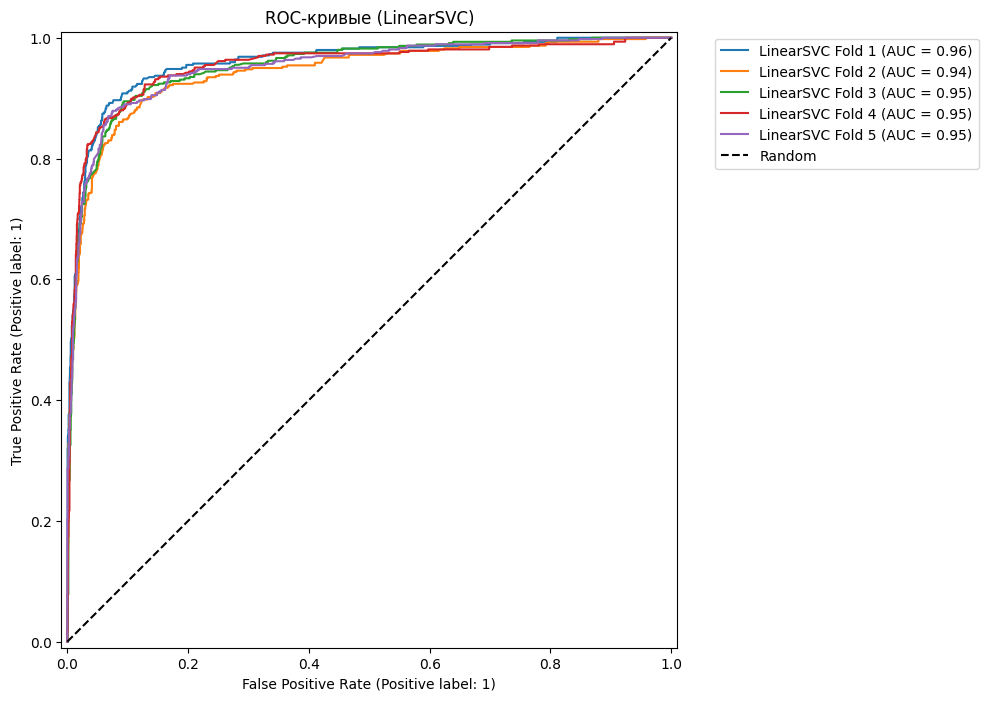


–†–µ–∑—É–ª—å—Ç–∞—Ç—ã –≤–∞–ª–∏–¥–∞—Ü–∏–∏:
–ú–æ–¥–µ–ª—å: LinearSVC
–°—Ä–µ–¥–Ω–∏–π AUC: 0.947
–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è –∑–∞—è–≤–∫–∏: 0.904 ¬± 0.021
–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ —Ä–∞–±–æ—Ç—ã —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–æ–≤: 0.952 ¬± 0.011
–ù—Ä–∞–≤–∏—Ç—Å—è —Å–∫–æ—Ä–æ—Å—Ç—å –æ—Ç—Ä–∞–±–æ—Ç–∫–∏ –∑–∞—è–≤–æ–∫: 0.965 ¬± 0.015
–í–æ–ø—Ä–æ—Å —Ä–µ—à–µ–Ω: 0.927 ¬± 0.019
–í–æ–ø—Ä–æ—Å –Ω–µ —Ä–µ—à–µ–Ω: 0.989 ¬± 0.003

–¢–µ—Å—Ç–æ–≤—ã–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è:

–û—Ç–∑—ã–≤ 1:
–¢–µ–∫—Å—Ç: –ë—ã—Å—Ç—Ä–æ –∏ –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω–æ –≤—ã–ø–æ–ª–Ω–∏–ª–∏ —Ä–∞–±–æ—Ç—É
–ö–∞—Ç–µ–≥–æ—Ä–∏–∏:
  –í–æ–ø—Ä–æ—Å —Ä–µ—à–µ–Ω: 0.337
–ú–∞–∫—Å. –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å: 0.337

–û—Ç–∑—ã–≤ 2:
–¢–µ–∫—Å—Ç: –ü—Ä–∏—à–ª–æ—Å—å –∂–¥–∞—Ç—å —Ç—Ä–∏ –¥–Ω—è, —Ä–µ–∑—É–ª—å—Ç–∞—Ç –ø–ª–æ—Ö–æ–π
–ö–∞—Ç–µ–≥–æ—Ä–∏–∏: –Ω–µ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω—ã
–ú–∞–∫—Å. –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å: 0.163

–û—Ç–∑—ã–≤ 3:
–¢–µ–∫—Å—Ç: 
–ö–∞—Ç–µ–≥–æ—Ä–∏–∏: –Ω–µ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω—ã
–ú–∞–∫—Å. –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å: 0.000

–û—Ç–∑—ã–≤ 4:
–¢–µ–∫—Å—Ç: –°–æ—Ç—

In [44]:
#–ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –∏–Ω—Å—Ç—Ä—É–º–µ–Ω—Ç–æ–≤ –¥–ª—è –ø—Ä–µ–ø—Ä–æ—Ü–µ—Å—Å–∏–Ω–≥–∞
morph = MorphAnalyzer()

#–§—É–Ω–∫—Ü–∏–∏ –ø—Ä–µ–ø—Ä–æ—Ü–µ—Å—Å–∏–Ω–≥–∞ —Ç–µ–∫—Å—Ç–∞
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'\b–Ω–µ\s+(\w+)', r'–Ω–µ_\1', text)
    words = []
    for word in re.findall(r'\b[\w-]+\b', text):
        p = morph.parse(word)[0]
        words.append(p.normal_form)
    return ' '.join(words)

#–ó–∞–≥—Ä—É–∑–∫–∞ –∏ –ø–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö
def load_and_prepare_data(file_path='processed_data_final1.csv'):
    df = pd.read_csv(file_path, encoding='utf-8')
    
    text_columns = [col for col in df.columns if df[col].dtype == 'object' and df[col].str.len().mean() > 20]
    text_column = text_columns[0]
    print(f"\n–ù–∞–π–¥–µ–Ω–∞ —Ç–µ–∫—Å—Ç–æ–≤–∞—è –∫–æ–ª–æ–Ω–∫–∞: '{text_column}'")
    
    tqdm.pandas(desc="–û–±—Ä–∞–±–æ—Ç–∫–∞ —Ç–µ–∫—Å—Ç–∞")
    df['processed_text'] = df[text_column].progress_apply(preprocess_text)
    
    categories = [
        '–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è –∑–∞—è–≤–∫–∏',
        '–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ —Ä–∞–±–æ—Ç—ã —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–æ–≤',
        '–ù—Ä–∞–≤–∏—Ç—Å—è —Å–∫–æ—Ä–æ—Å—Ç—å –æ—Ç—Ä–∞–±–æ—Ç–∫–∏ –∑–∞—è–≤–æ–∫',
        '–í–æ–ø—Ä–æ—Å —Ä–µ—à–µ–Ω',
        '–í–æ–ø—Ä–æ—Å –Ω–µ —Ä–µ—à–µ–Ω'
    ]
    
    df = df.dropna(subset=categories)
    print(f"\n–£—Å–ø–µ—à–Ω–æ –æ–±—Ä–∞–±–æ—Ç–∞–Ω–æ {len(df)} –∑–∞–ø–∏—Å–µ–π")
    
    return df['processed_text'].values, df[categories].values, categories

#–ü–∞–π–ø–ª–∞–π–Ω –º–æ–¥–µ–ª–∏
def build_model():
    return make_pipeline(
        TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 2),
            min_df=3,
            max_df=0.85
        ),
        OneVsRestClassifier(
            CalibratedClassifierCV(
                LinearSVC(
                    C=0.9,
                    class_weight='balanced',
                    max_iter=10000,
                    random_state=42,
                    penalty='l2',
                    loss='squared_hinge'
                )
            )
        )
    )

#–ö—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏—è
def cross_validate(X, y, categories, model_name, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {
        'auc_scores': [],
        'category_auc': {c: [] for c in categories}
    }
    
    plt.figure(figsize=(10, 8))
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y.argmax(1))):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = build_model()
        model.fit(X_train, y_train)
        
        y_proba = model.predict_proba(X_test)
        
        fold_auc = roc_auc_score(y_test, y_proba, average='macro')
        results['auc_scores'].append(fold_auc)
        
        for i, cat in enumerate(categories):
            results['category_auc'][cat].append(roc_auc_score(y_test[:,i], y_proba[:,i]))
        
        RocCurveDisplay.from_predictions(
            LabelBinarizer().fit_transform(y_test).ravel(),
            y_proba.ravel(),
            name=f"{model_name} Fold {fold+1}",
            ax=plt.gca()
        )
    
    plt.plot([0,1], [0,1], 'k--', label="Random")
    plt.title(f'ROC-–∫—Ä–∏–≤—ã–µ ({model_name})')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    return results

#–ì–µ–Ω–µ—Ä–∞—Ü–∏—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π
def predict_with_threshold(model, texts, categories, threshold=0.25):
    processed = [preprocess_text(t) if t.strip() else '' for t in texts]
    probas = model.predict_proba(processed)
    
    predictions = []
    for text, proba in zip(texts, probas):
        prediction = {
            'text': text,
            'categories': [],
            'probabilities': {},
            'max_score': 0.0
        }
        
        if not text.strip():
            predictions.append(prediction)
            continue
        
        max_score = np.max(proba)
        selected = [(cat, score) for cat, score in zip(categories, proba) if score >= max(threshold, max_score)]
        
        prediction['categories'] = [cat for cat, _ in selected]
        prediction['probabilities'] = {cat: float(score) for cat, score in zip(categories, proba)}
        prediction['max_score'] = float(max_score)
        
        predictions.append(prediction)
    
    return predictions

#–ì–ª–∞–≤–Ω–∞—è —Ñ—É–Ω–∫—Ü–∏—è
def main():
    X, y, cats = load_and_prepare_data()
    model = build_model()
    model_name = "LinearSVC"
    
    print("\n–û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏...")
    model.fit(X, y)
    
    print("\n–ö—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏—è...")
    cv_results = cross_validate(X, y, cats, model_name)
    
    print("\n–†–µ–∑—É–ª—å—Ç–∞—Ç—ã –≤–∞–ª–∏–¥–∞—Ü–∏–∏:")
    print(f"–ú–æ–¥–µ–ª—å: {model_name}")
    print(f"–°—Ä–µ–¥–Ω–∏–π AUC: {np.mean(cv_results['auc_scores']):.3f}")
    for cat in cats:
        scores = cv_results['category_auc'][cat]
        print(f"{cat}: {np.mean(scores):.3f} ¬± {np.std(scores):.3f}")

    test_texts = [
        "–ë—ã—Å—Ç—Ä–æ –∏ –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω–æ –≤—ã–ø–æ–ª–Ω–∏–ª–∏ —Ä–∞–±–æ—Ç—É",
        "–ü—Ä–∏—à–ª–æ—Å—å –∂–¥–∞—Ç—å —Ç—Ä–∏ –¥–Ω—è, —Ä–µ–∑—É–ª—å—Ç–∞—Ç –ø–ª–æ—Ö–æ–π",
        "",
        "–°–æ—Ç—Ä—É–¥–Ω–∏–∫ –æ–ø–æ–∑–¥–∞–ª, –Ω–æ –ø—Ä–æ–±–ª–µ–º—É —Ä–µ—à–∏–ª",
        "–ù–∏–∫—Ç–æ –Ω–µ –ø—Ä–∏–µ—Ö–∞–ª, –æ–±—Å–ª—É–∂–∏–≤–∞–Ω–∏–µ —É–∂–∞—Å–Ω–æ–µ",
        "–°–æ—Ç—Ä—É–¥–Ω–∏–∫–∏ —Ä–∞–±–æ—Ç–∞—é—Ç –æ–ø–µ—Ä–∞—Ç–∏–≤–Ω–æ, –∑–∞—è–≤–∫–∞ –≤—ã–ø–æ–ª–Ω–µ–Ω–∞ –≤ —Å—Ä–æ–∫.",
        "–ö–∞—á–µ—Å—Ç–≤–æ —É—Å–ª—É–≥ –Ω–∞ –≤—ã—Å–æ—Ç–µ, –Ω–æ –ø—Ä–∏—à–ª–æ—Å—å –¥–æ–ª–≥–æ –∂–¥–∞—Ç—å –æ—Ç–≤–µ—Ç–∞.",
        "–ü—Ä–æ–±–ª–µ–º–∞ –æ—Å—Ç–∞–ª–∞—Å—å –Ω–µ—Ä–µ—à–µ–Ω–Ω–æ–π, –æ—á–µ–Ω—å —Ä–∞–∑–æ—á–∞—Ä–æ–≤–∞–Ω.",
        "–ë—ã—Å—Ç—Ä–æ –ø—Ä–∏–µ—Ö–∞–ª–∏ –∏ –≤—Å–µ –ø–æ—á–∏–Ω–∏–ª–∏, –º–æ–ª–æ–¥—Ü—ã!",
        "–°–æ—Ç—Ä—É–¥–Ω–∏–∫ –±—ã–ª –≤–µ–∂–ª–∏–≤, –Ω–æ —Ä–µ—à–µ–Ω–∏–µ –∑–∞–Ω—è–ª–æ –º–Ω–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏.",
        "–ó–∞—è–≤–∫—É –≤—ã–ø–æ–ª–Ω–∏–ª–∏ –Ω–µ–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω–æ, –ø—Ä–∏—à–ª–æ—Å—å –ø–µ—Ä–µ–¥–µ–ª—ã–≤–∞—Ç—å.",
        "–ù–∏–∫–∞–∫–æ–π –æ–±—Ä–∞—Ç–Ω–æ–π —Å–≤—è–∑–∏, –≤–æ–ø—Ä–æ—Å —Ç–∞–∫ –∏ –≤–∏—Å–∏—Ç.",
        "–ú–æ–ª–Ω–∏–µ–Ω–æ—Å–Ω–∞—è —Ä–µ–∞–∫—Ü–∏—è –∏ –ø—Ä–æ—Ñ–µ—Å—Å–∏–æ–Ω–∞–ª—å–Ω—ã–π –ø–æ–¥—Ö–æ–¥!",
        "–†–∞–±–æ—Ç–∞ —Å–¥–µ–ª–∞–Ω–∞ —Ö–æ—Ä–æ—à–æ, –Ω–æ —Å–æ—Ç—Ä—É–¥–Ω–∏–∫ –æ–ø–æ–∑–¥–∞–ª –Ω–∞ –≤—Å—Ç—Ä–µ—á—É.",
        "–î–æ —Å–∏—Ö –ø–æ—Ä –Ω–µ—Ç –æ—Ç–≤–µ—Ç–∞, –ø—Ä–æ—à–ª–æ —É–∂–µ —Ç—Ä–∏ –¥–Ω—è."
    ]
    
    print("\n–¢–µ—Å—Ç–æ–≤—ã–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è:")
    predictions = predict_with_threshold(model, test_texts, cats, 0.25)
    
    for i, pred in enumerate(predictions):
        print(f"\n–û—Ç–∑—ã–≤ {i+1}:")
        print(f"–¢–µ–∫—Å—Ç: {pred['text']}")
        if pred['categories']:
            print("–ö–∞—Ç–µ–≥–æ—Ä–∏–∏:")
            for cat in pred['categories']:
                print(f"  {cat}: {pred['probabilities'][cat]:.3f}")
        else:
            print("–ö–∞—Ç–µ–≥–æ—Ä–∏–∏: –Ω–µ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω—ã")
        print(f"–ú–∞–∫—Å. –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å: {pred['max_score']:.3f}")

if __name__ == "__main__":
    main()

–û–±—Ä–∞–±–æ—Ç–∫–∞ —Ç–µ–∫—Å—Ç–∞:   0%|          | 0/2737 [00:00<?, ?it/s]


–†–µ–∑—É–ª—å—Ç–∞—Ç—ã –≤–∞–ª–∏–¥–∞—Ü–∏–∏:


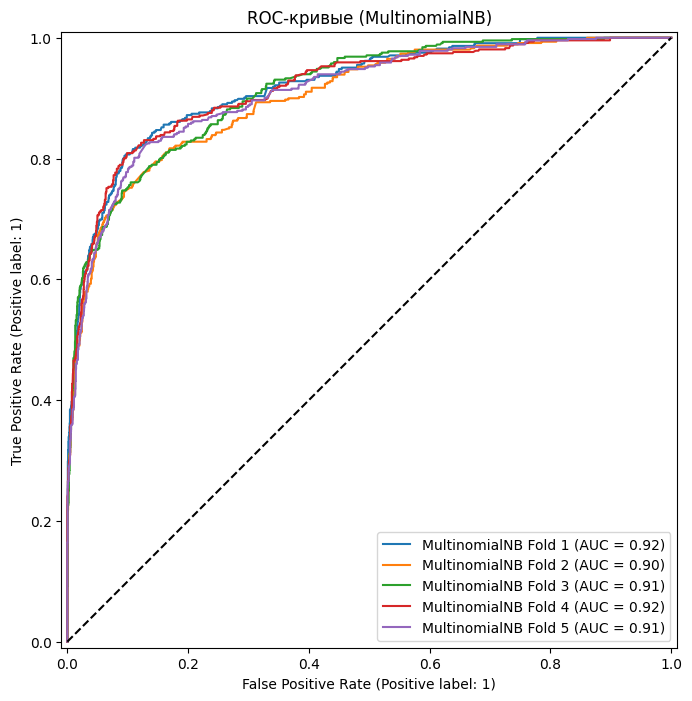

–°—Ä–µ–¥–Ω–∏–π AUC: 0.908
–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è –∑–∞—è–≤–∫–∏: 0.841
–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ —Ä–∞–±–æ—Ç—ã —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–æ–≤: 0.916
–ù—Ä–∞–≤–∏—Ç—Å—è —Å–∫–æ—Ä–æ—Å—Ç—å –æ—Ç—Ä–∞–±–æ—Ç–∫–∏ –∑–∞—è–≤–æ–∫: 0.939
–í–æ–ø—Ä–æ—Å —Ä–µ—à–µ–Ω: 0.863
–í–æ–ø—Ä–æ—Å –Ω–µ —Ä–µ—à–µ–Ω: 0.980

–¢–µ—Å—Ç–æ–≤—ã–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è:

–û—Ç–∑—ã–≤ 1:
–¢–µ–∫—Å—Ç: –ë—ã—Å—Ç—Ä–æ –∏ –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω–æ –≤—ã–ø–æ–ª–Ω–∏–ª–∏ —Ä–∞–±–æ—Ç—É
–ö–∞—Ç–µ–≥–æ—Ä–∏–∏: ['–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ —Ä–∞–±–æ—Ç—ã —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–æ–≤']

–û—Ç–∑—ã–≤ 2:
–¢–µ–∫—Å—Ç: –ü—Ä–∏—à–ª–æ—Å—å –∂–¥–∞—Ç—å —Ç—Ä–∏ –¥–Ω—è, —Ä–µ–∑—É–ª—å—Ç–∞—Ç –ø–ª–æ—Ö–æ–π
–ö–∞—Ç–µ–≥–æ—Ä–∏–∏: ['–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è –∑–∞—è–≤–∫–∏']

–û—Ç–∑—ã–≤ 3:
–¢–µ–∫—Å—Ç: 
–ö–∞—Ç–µ–≥–æ—Ä–∏–∏: []

–û—Ç–∑—ã–≤ 4:
–¢–µ–∫—Å—Ç: –°–æ—Ç—Ä—É–¥–Ω–∏–∫ –æ–ø–æ–∑–¥–∞–ª, –Ω–æ –ø—Ä–æ–±–ª–µ–º—É —Ä–µ—à–∏–ª
–ö–∞—Ç–µ–≥–æ—Ä–∏–∏: ['–í–æ–ø—Ä–æ—Å —Ä–µ—à–µ–Ω']

–û—Ç–∑—ã–≤ 5:
–¢–µ–∫—Å—Ç: –ù–∏–∫—Ç–æ –Ω–µ –ø—Ä–∏–µ—Ö–∞–ª,

In [46]:

#–ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –∏–Ω—Å—Ç—Ä—É–º–µ–Ω—Ç–æ–≤ –¥–ª—è –ø—Ä–µ–ø—Ä–æ—Ü–µ—Å—Å–∏–Ω–≥–∞
morph = MorphAnalyzer()

#–§—É–Ω–∫—Ü–∏–∏ –ø—Ä–µ–ø—Ä–æ—Ü–µ—Å—Å–∏–Ω–≥–∞ —Ç–µ–∫—Å—Ç–∞
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'\b–Ω–µ\s+(\w+)', r'–Ω–µ_\1', text)
    words = []
    for word in re.findall(r'\b[\w-]+\b', text):
        p = morph.parse(word)[0]
        words.append(p.normal_form)
    return ' '.join(words)

#–ó–∞–≥—Ä—É–∑–∫–∞ –∏ –ø–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö
def load_and_prepare_data(file_path='processed_data_final1.csv'):
    df = pd.read_csv(file_path, encoding='utf-8')
    
    #–ü–æ–∏—Å–∫ —Ç–µ–∫—Å—Ç–æ–≤–æ–π –∫–æ–ª–æ–Ω–∫–∏
    text_column = [col for col in df.columns 
                  if df[col].dtype == 'object' and df[col].str.len().mean() > 20][0]
    
    #–ü—Ä–µ–ø—Ä–æ—Ü–µ—Å—Å–∏–Ω–≥ —Ç–µ–∫—Å—Ç–∞
    tqdm.pandas(desc="–û–±—Ä–∞–±–æ—Ç–∫–∞ —Ç–µ–∫—Å—Ç–∞")
    df['processed_text'] = df[text_column].progress_apply(preprocess_text)
    
    #–û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–π
    categories = [
        '–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ –≤—ã–ø–æ–ª–Ω–µ–Ω–∏—è –∑–∞—è–≤–∫–∏',
        '–ù—Ä–∞–≤–∏—Ç—Å—è –∫–∞—á–µ—Å—Ç–≤–æ —Ä–∞–±–æ—Ç—ã —Å–æ—Ç—Ä—É–¥–Ω–∏–∫–æ–≤',
        '–ù—Ä–∞–≤–∏—Ç—Å—è —Å–∫–æ—Ä–æ—Å—Ç—å –æ—Ç—Ä–∞–±–æ—Ç–∫–∏ –∑–∞—è–≤–æ–∫',
        '–í–æ–ø—Ä–æ—Å —Ä–µ—à–µ–Ω',
        '–í–æ–ø—Ä–æ—Å –Ω–µ —Ä–µ—à–µ–Ω'
    ]
    
    df = df.dropna(subset=categories)
    return df['processed_text'].values, df[categories].values, categories

#–ü–∞–π–ø–ª–∞–π–Ω –º–æ–¥–µ–ª–∏
def build_model():
    return make_pipeline(
        TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 2),
            min_df=3,
            max_df=0.85
        ),
        OneVsRestClassifier(MultinomialNB(alpha=0.7))
    )

#–ö—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏—è
def cross_validate(X, y, categories, model_name, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {'auc_scores': [], 'category_auc': {c: [] for c in categories}}
    
    plt.figure(figsize=(10, 8))
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y.argmax(1))):
        model = build_model().fit(X[train_idx], y[train_idx])
        y_proba = model.predict_proba(X[test_idx])
        
        results['auc_scores'].append(roc_auc_score(y[test_idx], y_proba, average='macro'))
        for i, cat in enumerate(categories):
            results['category_auc'][cat].append(roc_auc_score(y[test_idx][:,i], y_proba[:,i]))
        
        RocCurveDisplay.from_predictions(
            LabelBinarizer().fit_transform(y[test_idx]).ravel(),
            y_proba.ravel(),
            name=f"{model_name} Fold {fold+1}",
            ax=plt.gca()
        )
    
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f'ROC-–∫—Ä–∏–≤—ã–µ ({model_name})')
    plt.legend()
    plt.show()
    return results

#–ì–µ–Ω–µ—Ä–∞—Ü–∏—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π
def predict_with_threshold(model, texts, categories, threshold=0.25):
    processed = [preprocess_text(t) for t in texts]
    probas = model.predict_proba(processed)
    
    predictions = []
    for text, proba in zip(texts, probas):
        prediction = {
            'text': text,
            'categories': [],
            'probabilities': dict(zip(categories, proba)),
            'max_score': float(np.max(proba))
        }
        
        #–í—Å–µ–≥–¥–∞ –≤—ã–±–∏—Ä–∞–µ–º —Ö–æ—Ç—è –±—ã –æ–¥–Ω—É –∫–∞—Ç–µ–≥–æ—Ä–∏—é –¥–ª—è –Ω–µ–ø—É—Å—Ç–æ–≥–æ —Ç–µ–∫—Å—Ç–∞
        if text.strip():
            #–ù–∞—Ö–æ–¥–∏–º –≤—Å–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∏ –≤—ã—à–µ –ø–æ—Ä–æ–≥–∞
            above_threshold = [(cat, score) for cat, score in zip(categories, proba) if score >= threshold]
            
            #–ï—Å–ª–∏ –Ω–µ—Ç –∫–∞—Ç–µ–≥–æ—Ä–∏–π –≤—ã—à–µ –ø–æ—Ä–æ–≥–∞ - –±–µ—Ä–µ–º –º–∞–∫—Å–∏–º–∞–ª—å–Ω—É—é
            if not above_threshold:
                max_idx = np.argmax(proba)
                prediction['categories'] = [categories[max_idx]]
            else:
                prediction['categories'] = [cat for cat, _ in above_threshold]
        
        predictions.append(prediction)
    
    return predictions

#–ì–ª–∞–≤–Ω–∞—è —Ñ—É–Ω–∫—Ü–∏—è
def main():
    X, y, cats = load_and_prepare_data()
    model = build_model().fit(X, y)
    
    print("\n–†–µ–∑—É–ª—å—Ç–∞—Ç—ã –≤–∞–ª–∏–¥–∞—Ü–∏–∏:")
    cv_results = cross_validate(X, y, cats, "MultinomialNB")
    print(f"–°—Ä–µ–¥–Ω–∏–π AUC: {np.mean(cv_results['auc_scores']):.3f}")
    for cat in cats:
        print(f"{cat}: {np.mean(cv_results['category_auc'][cat]):.3f}")

    test_texts = [
        "–ë—ã—Å—Ç—Ä–æ –∏ –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω–æ –≤—ã–ø–æ–ª–Ω–∏–ª–∏ —Ä–∞–±–æ—Ç—É",
        "–ü—Ä–∏—à–ª–æ—Å—å –∂–¥–∞—Ç—å —Ç—Ä–∏ –¥–Ω—è, —Ä–µ–∑—É–ª—å—Ç–∞—Ç –ø–ª–æ—Ö–æ–π",
        "",
        "–°–æ—Ç—Ä—É–¥–Ω–∏–∫ –æ–ø–æ–∑–¥–∞–ª, –Ω–æ –ø—Ä–æ–±–ª–µ–º—É —Ä–µ—à–∏–ª",
        "–ù–∏–∫—Ç–æ –Ω–µ –ø—Ä–∏–µ—Ö–∞–ª, –æ–±—Å–ª—É–∂–∏–≤–∞–Ω–∏–µ —É–∂–∞—Å–Ω–æ–µ",
        "–°–æ—Ç—Ä—É–¥–Ω–∏–∫–∏ —Ä–∞–±–æ—Ç–∞—é—Ç –æ–ø–µ—Ä–∞—Ç–∏–≤–Ω–æ, –∑–∞—è–≤–∫–∞ –≤—ã–ø–æ–ª–Ω–µ–Ω–∞ –≤ —Å—Ä–æ–∫.",
        "–ö–∞—á–µ—Å—Ç–≤–æ —É—Å–ª—É–≥ –Ω–∞ –≤—ã—Å–æ—Ç–µ, –Ω–æ –ø—Ä–∏—à–ª–æ—Å—å –¥–æ–ª–≥–æ –∂–¥–∞—Ç—å –æ—Ç–≤–µ—Ç–∞.",
        "–ü—Ä–æ–±–ª–µ–º–∞ –æ—Å—Ç–∞–ª–∞—Å—å –Ω–µ—Ä–µ—à–µ–Ω–Ω–æ–π, –æ—á–µ–Ω—å —Ä–∞–∑–æ—á–∞—Ä–æ–≤–∞–Ω.",
        "–ë—ã—Å—Ç—Ä–æ –ø—Ä–∏–µ—Ö–∞–ª–∏ –∏ –≤—Å–µ –ø–æ—á–∏–Ω–∏–ª–∏, –º–æ–ª–æ–¥—Ü—ã!",
        "–°–æ—Ç—Ä—É–¥–Ω–∏–∫ –±—ã–ª –≤–µ–∂–ª–∏–≤, –Ω–æ —Ä–µ—à–µ–Ω–∏–µ –∑–∞–Ω—è–ª–æ –º–Ω–æ–≥–æ –≤—Ä–µ–º–µ–Ω–∏.",
        "–ó–∞—è–≤–∫—É –≤—ã–ø–æ–ª–Ω–∏–ª–∏ –Ω–µ–∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω–æ, –ø—Ä–∏—à–ª–æ—Å—å –ø–µ—Ä–µ–¥–µ–ª—ã–≤–∞—Ç—å.",
        "–ù–∏–∫–∞–∫–æ–π –æ–±—Ä–∞—Ç–Ω–æ–π —Å–≤—è–∑–∏, –≤–æ–ø—Ä–æ—Å —Ç–∞–∫ –∏ –≤–∏—Å–∏—Ç.",
        "–ú–æ–ª–Ω–∏–µ–Ω–æ—Å–Ω–∞—è —Ä–µ–∞–∫—Ü–∏—è –∏ –ø—Ä–æ—Ñ–µ—Å—Å–∏–æ–Ω–∞–ª—å–Ω—ã–π –ø–æ–¥—Ö–æ–¥!",
        "–†–∞–±–æ—Ç–∞ —Å–¥–µ–ª–∞–Ω–∞ —Ö–æ—Ä–æ—à–æ, –Ω–æ —Å–æ—Ç—Ä—É–¥–Ω–∏–∫ –æ–ø–æ–∑–¥–∞–ª –Ω–∞ –≤—Å—Ç—Ä–µ—á—É.",
        "–î–æ —Å–∏—Ö –ø–æ—Ä –Ω–µ—Ç –æ—Ç–≤–µ—Ç–∞, –ø—Ä–æ—à–ª–æ —É–∂–µ —Ç—Ä–∏ –¥–Ω—è."
    ]
    print("\n–¢–µ—Å—Ç–æ–≤—ã–µ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è:")
    predictions = predict_with_threshold(model, test_texts, cats)
    for i, pred in enumerate(predictions):
        print(f"\n–û—Ç–∑—ã–≤ {i+1}:\n–¢–µ–∫—Å—Ç: {pred['text']}\n–ö–∞—Ç–µ–≥–æ—Ä–∏–∏: {pred['categories']}")

if __name__ == "__main__":
    main()